In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import datetime as dt
from dateutil.relativedelta import relativedelta #source: https://dateutil.readthedocs.io/en/stable/

# Custom functions file this project
from my_functions import get_date_str, declutter_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# Adding options to display all of the rows of DataFrame w/o truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Set-up tentative vacation dates in 2020
start_date_of_vacation = dt.datetime(2020, 9, 8)
end_date_of_vacation = dt.datetime(2020, 9, 18)

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['measurement', 'station']


In [5]:
for table in table_names:    
    columns_in_table = inspector.get_columns(table)
    print(f"Table: '{table}' contains {len(columns_in_table)} columns. ")
    
    for column in columns_in_table:
        print(f'{column["name"]}, {column["type"]}')
    print('\n')

Table: 'measurement' contains 5 columns. 
id, INTEGER
station, TEXT
date, TEXT
prcp, FLOAT
tobs, FLOAT


Table: 'station' contains 6 columns. 
id, INTEGER
station, TEXT
name, TEXT
latitude, FLOAT
longitude, FLOAT
elevation, FLOAT




In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# sanity check for columns read
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
session = Session(engine)

## Exploratory Climate Analysis

 ### 1. Last 12 months of precicpitation data

In [9]:
# Find most recent data entry in the data set
result = session.query(Measurement.id, \
                        Measurement.station, \
                        Measurement.date, \
                        Measurement.prcp, \
                        Measurement.tobs).\
                        order_by(Measurement.id.desc()).\
                        first()
print(result)

(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)


In [10]:
# Grab the most recent entry in the database and find 12 month prior date programatically
most_recent_entry_date = result[2]
most_recent_entry_date = dt.datetime.strptime(most_recent_entry_date, '%Y-%m-%d')
print(f'Date of last entry in the database: {most_recent_entry_date.strftime("%b")} {most_recent_entry_date.day}, {most_recent_entry_date.year}')

twelve_months_prior_date = most_recent_entry_date - relativedelta(months=12)
print(f'Twelve months prior date: {twelve_months_prior_date.strftime("%b")} {twelve_months_prior_date.day}, {twelve_months_prior_date.year}')

Date of last entry in the database: Aug 23, 2017
Twelve months prior date: Aug 23, 2016


In [11]:
# Retrieve last 12 months of precipitation data from the most recent entry in the database
results = session.query(Measurement.date,\
                       Measurement.prcp).\
                       filter(func.strftime("%Y-%m-%d", Measurement.date) >= get_date_str(twelve_months_prior_date)).\
                       all()
# Sanity check
print(len(results))

2230


In [12]:
date_list = [row[0] for row in results]
precipitation_list = [row[1] for row in results]

precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precipitation_df = precipitation_df.set_index('date')
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [ ]:
# write out precipitation_df to csv for analysis
# output_path = os.path.join('Outputs','precipitation_df.csv')
# precipitation_df.to_csv(output_path)

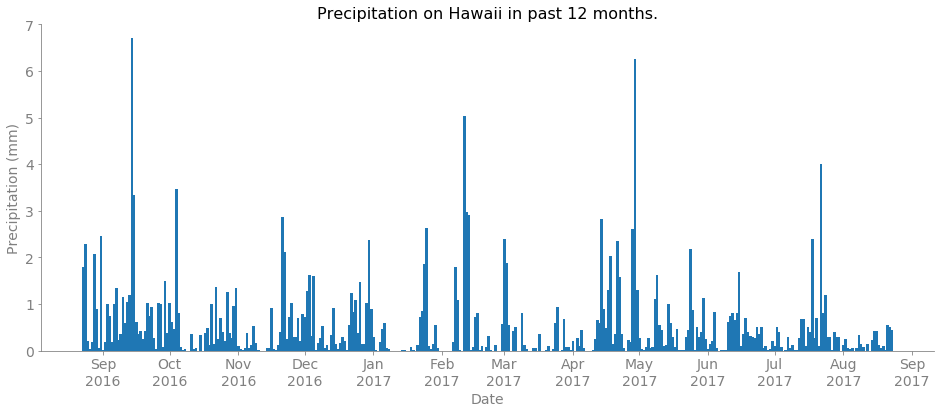

In [83]:
fig1, ax1 = plt.subplots(figsize=(16,6))
x_values = [dt.datetime.strptime(xval, '%Y-%m-%d') for xval in list(precipitation_df.reset_index()['date'])];
x_values = np.array(x_values)
y_values = list(precipitation_df['precipitation'])

# years = mdates.YearLocator()   # every year
# days = mdates.DayLocator()  # every day
# years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter("%b\n%Y")

ax1.bar(x_values, y_values, width=1.2)

# format the ticks
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(months_fmt)

ax1.set_ylim([0,7]);
declutter_plot(ax1)
ax1.set_ylabel('Precipitation (mm)', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title('Precipitation on Hawaii in past 12 months.', fontsize = 16);
# plt.savefig("Outputs/Images/precipitation.png", bbox_inches = 'tight', pad_inches = 1.0)
plt.show()

### Summary of Precipitation Data

In [86]:
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000
